In [1]:
cd ..

/home/hyunjun/workspace/FactorSearch (mom)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
kospi_ = pd.read_csv('data/data1/kospi.csv', index_col=0)['2015':'2024']
dates = kospi_.index
kospi = kospi_.values

pv_path = lambda algo, seed: f'result/seed{seed}/PV_{algo}.csv'
me_path = lambda algo, seed: f'result/seed{seed}/Me_{algo}.csv'
we_path = lambda algo, seed: f'result/seed{seed}/We_{algo}.csv'

pv_random = [pd.read_csv(pv_path('random', seed), index_col=0).values.reshape(-1,1) for seed in range(1, 5)]
re_random = [pd.read_csv(me_path('random', seed), index_col=0).values.reshape(-1,1) for seed in range(1, 5)]
we_random = [pd.read_csv(we_path('random', seed), index_col=0) for seed in range(1, 10)] 

pv_rl = [pd.read_csv(pv_path('RL', seed), index_col=0) for seed in range(1, 5)]
re_rl = [pd.read_csv(me_path('RL', seed), index_col=0) for seed in range(1, 5)]
we_rl = [pd.read_csv(we_path('RL', seed), index_col=0) for seed in range(1, 5)]

pv_mean_ran = np.mean(np.concatenate(pv_random, axis=-1), axis=-1)
pv_std_ran = np.std(np.concatenate(pv_random, axis=-1), axis=-1)
pv_mean_rl = np.mean(np.concatenate(pv_rl, axis=-1), axis=-1)
pv_std_rl = np.std(np.concatenate(pv_rl, axis=-1), axis=-1)

In [23]:
def get_alpha(pv):
    free = 0.04 / 12
    pv = np.array(pv).reshape(-1)
    R_i = (pv[1:] / pv[:-1]) - 1
    R_f = (kospi[1:] / kospi[:-1]) - 1
    R_f = R_f.reshape(-1)
    alpha = np.polyfit(R_f-free, R_i-free, 1)[-1]
    return alpha.reshape(1,-1)

In [ ]:
sharpe_random = np.concatenate(re_random, axis=-1)[0] 
rankic_random = np.concatenate(re_random, axis=-1)[1] 
mdd_random = np.concatenate(re_random, axis=-1)[2] 
alpha_random = np.concatenate(list(map(get_alpha, pv_random)), -1)

sharpe_rl = np.concatenate(re_rl, axis=-1)[0] 
rankic_rl = np.concatenate(re_rl, axis=-1)[1] 
mdd_rl = np.concatenate(re_rl, axis=-1)[2] 
alpha_rl = np.concatenate(list(map(get_alpha, pv_rl)), -1)

print(f'Random search Sharpe: {sharpe_random} \n')
print(f'Random search RankIC: {rankic_random} \n')
print(f'Random search MDD: {mdd_random} \n')
print(f'Random search Alpha: {alpha_random} \n')

print(f'RL search Sharpe: {sharpe_rl} \n')
print(f'RL search RankIC: {rankic_rl} \n')
print(f'RL search MDD: {mdd_rl} \n')
print(f'RL search Alpha: {alpha_rl} \n')

In [ ]:
index = 4

print(np.mean((pv_rl[index].values[1:] - pv_rl[index].values[:-1]) / (pv_rl[index].values[:-1])))
print(np.std((pv_rl[index].values[1:] - pv_rl[index].values[:-1]) / (pv_rl[index].values[:-1])))
we_rl[index].values

In [26]:
def show_plot(seed='all'):
    linewidth = 4.0
    beta = 0.5
    timesteps = [8*i for i in range(14)]

    sns.set(style='white')
    plt.figure(figsize=(25, 6))
    plt.rc('legend', fontsize=20)
    plt.xticks(timesteps, dates[timesteps], weight='bold', fontsize=13.5)
    plt.yticks(weight='bold', fontsize=13.5)
    plt.ylabel('Porftolio Value', weight='bold', fontsize=20)

    if seed == 'all':
        plt.plot(pv_mean_rl, color="C4", linewidth=linewidth, label='Felector search')
        plt.plot(pv_mean_ran, color="C7", linewidth=linewidth, label='Random search')

        plt.fill_between(x=np.arange(pv_mean_rl.shape[0]), 
                        y1=pv_mean_rl + beta*pv_std_rl, 
                        y2=pv_mean_rl - beta*pv_std_rl, 
                        alpha=0.3, color="C4")
        
        plt.fill_between(x=np.arange(pv_mean_ran.shape[0]), 
                        y1=pv_mean_ran + beta*pv_std_ran, 
                        y2=pv_mean_ran - beta*pv_std_ran, 
                        alpha=0.3, color="C7")

    else:
        plt.plot(pv_rl[seed-1], color="C4", linewidth=linewidth, label='Felector search')
        plt.plot(pv_random[seed-1], color="C7", linewidth=linewidth, label='Random search')

    plt.title('Test Dataset Backtesting', weight='bold', fontsize=20)
    plt.legend()
    plt.show()


def show_bar(seed):

    pvrl = pd.DataFrame(pv_rl[seed-1])
    pvra = pd.DataFrame(pv_random[seed-1])

    pvrl.index = dates
    pvra.index = dates

    first_rl = pvrl.groupby(by=pd.to_datetime(dates).year).first()
    last_rl = pvrl.groupby(by=pd.to_datetime(dates).year).last()

    first_ra = pvra.groupby(by=pd.to_datetime(dates).year).first()
    last_ra = pvra.groupby(by=pd.to_datetime(dates).year).last()

    year_rl = (last_rl-first_rl) / first_rl
    year_ra = (last_ra-first_ra) / first_ra

    w = 0.5
    plt.figure(figsize=(10,5))
    plt.rc('legend', fontsize=20)

    plt.xticks(ticks=np.arange(1,9)+0.15/2, labels=[str(i) for i in range(2016, 2024)], weight='bold', fontsize=13.5)
    plt.yticks(weight='bold', fontsize=13.5)
    plt.ylabel('Porftolio Value', weight='bold', fontsize=20)

    plt.bar(x=np.arange(1,9), height=year_rl['0'].values[1:], width=w, color='C4')
    plt.bar(x=np.arange(1,9)+0.15, height=year_ra[0].values[1:], width=w, color='C7')
    plt.title(f'Yearly Portfolio Return: Seed {seed}', weight='bold', fontsize=20)

    plt.show()

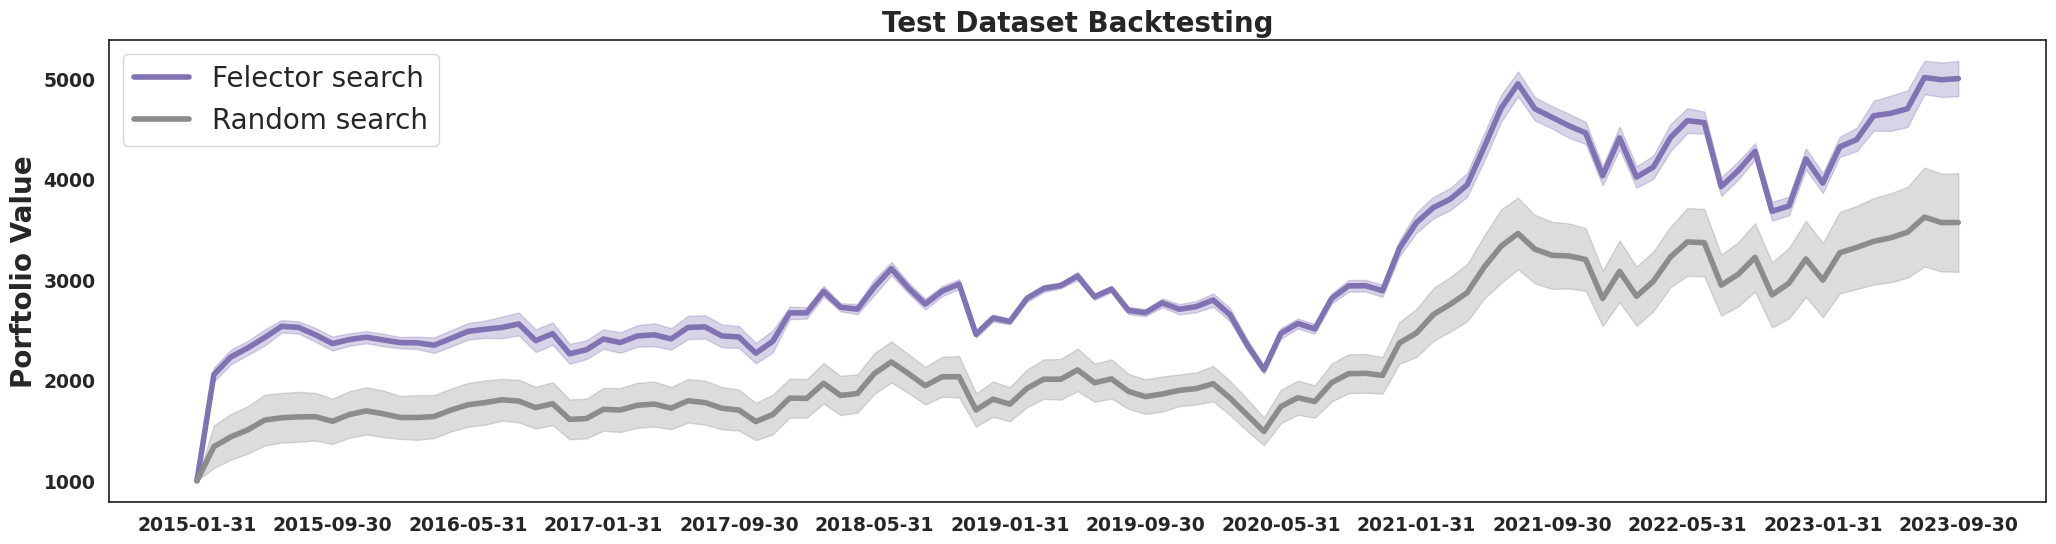

In [27]:
show_plot()

In [ ]:
show_bar(0)